# Checking fake data generation for dynamic variables (RT and max-d)

In [5]:
library(tmvtnorm)
library(ggplot2)
library(ggExtra)
library(brms)
library(reshape2)
library(coda)
library(mefa)
library(tidybayes)
library(ggstance)
library(tidyr)
library(ggthemes)
library(latex2exp)
library(viridis)

Loading required package: mvtnorm
Loading required package: Matrix
Loading required package: stats4
Loading required package: gmm
Loading required package: sandwich
Loading required package: Rcpp
Loading 'brms' package (version 2.4.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').
Run theme_set(theme_default()) to use the default bayesplot theme.
mefa 3.2-7 	 2016-01-11

Attaching package: 'mefa'

The following object is masked from 'package:reshape2':

    melt

NOTE: As of tidybayes version 1.0, several functions, arguments, and output column names
      have undergone significant name changes in order to adopt a unified naming scheme.
      See help('tidybayes-deprecated') for more information.


Attaching package: 'ggstance'

The following objects are masked from 'package:ggplot2':

    geom_errorbarh, GeomErrorbarh


Attaching package: 'tidyr'

The following object is masked from

## Generate data

In [3]:
get_pilot_data <- function(){
    data_path <- "D:/data/beyond_the_reach/pilot_and _power_analysis/pilot/choices_processed.csv"
    data <- read.table(data_path, header = TRUE, sep = ",")
    data[, 'subj_id'] <- factor(data[, 'subj_id'])
    data[, 'choice'] <- factor(data[, 'choice'])
    
    return(data)
}

sim_data_dyn <- function(true_model, pilot_data, var, n_batches, batch_size){
    # following the spirit of Kruschke (2014), we use a part pilot data to generate new values of DV's
    # we first generate fake subject id's
    fake_subj_ids <- vector(mode = "numeric", length = 0)
    for (i in 1:n_batches){    
        fake_subj_ids <- c(fake_subj_ids, sort(rep(sample(1001:9999, batch_size, replace = F), 47))[1:nrow(pilot_data)])
    }
    
    # then, we repeat the pilot data several times changing subj_ids to fake subjects along the way
    fake_data <- rep(pilot_data, n_batches)
    fake_data$subj_id <- fake_subj_ids
        
    # finally, we replace the DV's values in the pilot data by fake values generated by the 'true' model
    # so if our 'true' model is intercept-only, the DV will not have any relation to choice or lambda (on average)
    fake_var <- predict(true_model, newdata = fake_data, allow_new_levels = T, 
                        sample_new_levels = 'gaussian', subset = 1)
    fake_data[,var] <- fake_var[,1]
    return(fake_data)
}

Just to check that the fake data generation works, we fit the full model to pilot data, then generate the fake data based on full model, and visually inspect the subject-level intercepts (for SS and LL choices separately)

In [28]:
fit_model <- function(data, var, effect){
    rscale <- 0.707
    prior <- c(set_prior(sprintf('normal(%f, %f)', mean(data[, var]), sd(data[, var])), class = "Intercept"),
               set_prior(sprintf('cauchy(0, %f)', rscale*sd(data[, var])/sd(data[, 'Lambda'])), class = "b"))

    formulas <- list(f_inter = as.formula(paste(var, "~ (choice | subj_id) + Lambda:choice")),
                     f_choice = as.formula(paste(var, "~ (choice | subj_id)")),
                     f_null = as.formula(paste(var, "~ (1 | subj_id)")))

    if (effect == 'null'){
        formula <- formulas$f_null
        prior <- prior[1,]
    } else if (effect == 'choice'){
        formula <- formulas$f_choice
        prior <- prior[1,]
    } else if (effect == 'inter'){
        formula <- formulas$f_inter
    }

    model <- brm(formula, data = data, family = gaussian(), save_all_pars = TRUE,
               control = list(adapt_delta = 0.99), prior = prior)    
    return(model)
}

In [29]:
var <- 'RT'

pilot_data <- get_pilot_data()
true_model <- fit_model(pilot_data, var, 'choice')

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 3.009 seconds (Warm-up)
               2.182 seconds (Sampling)
               5.191 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust y

We use `tidybayes` to visualize subject-level intercepts in pilot data. As we're hypothesizing the effect of choice as well, we do it separately for SS and LL choices

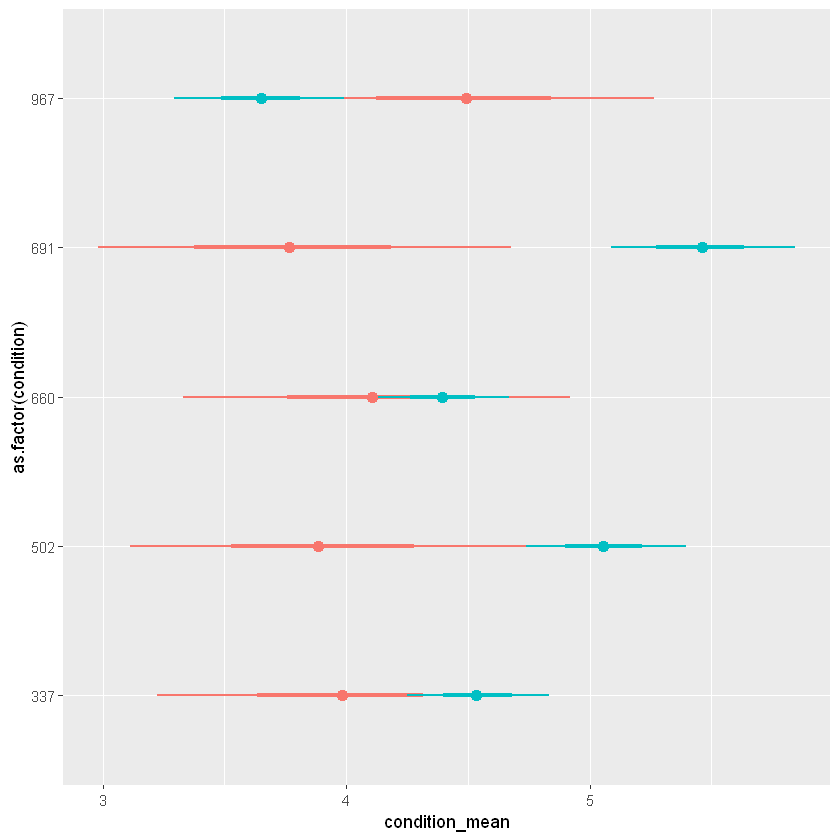

In [23]:
true_model %>%
  spread_draws(b_Intercept, r_subj_id[condition,term]) %>%
  median_qi(condition_mean = b_Intercept + r_subj_id, .width = c(.95, .66)) %>%
  ggplot(aes(y = as.factor(condition), x = condition_mean, color=term))+
  geom_pointintervalh() 

Now let's generate the fake data with the desired effects (coded by `true_model`)

In [16]:
fake_data <- sim_data_dyn(true_model = true_model, pilot_data = pilot_data, var = 'RT', n_batches=6, batch_size=5)

Now we can check what the patterns are in the fake data by fitting our full model to this data

In [26]:
m_inter <- fit_model(fake_data, var, 'inter')

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 1).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 18.667 seconds (Warm-up)
               19.022 seconds (Sampling)
               37.689 seconds (Total)


SAMPLING FOR MODEL 'gaussian brms-model' NOW (CHAIN 2).

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjus

For instance, we can see if the generated DV has reasonable subject-level intercepts. They should be on average different between SS and LL if our true model includes main effect of choice, or they should be more-less random if the true model is intercept-only

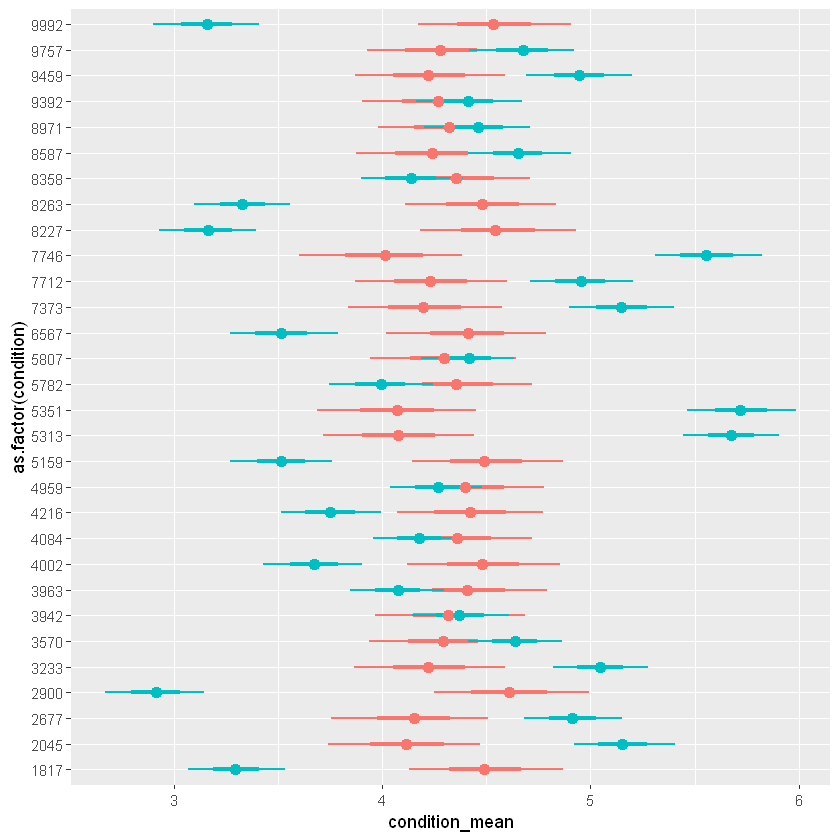

In [27]:
m_inter %>%
  spread_draws(b_Intercept, r_subj_id[condition,term]) %>%
  median_qi(condition_mean = b_Intercept + r_subj_id, .width = c(.95, .66)) %>%
  ggplot(aes(y = as.factor(condition), x = condition_mean, color=term))+
  geom_pointintervalh() 

Or we can look at the posterior samples from the distribution of the choice-by-lambda interaction effect (the only population-level effect)

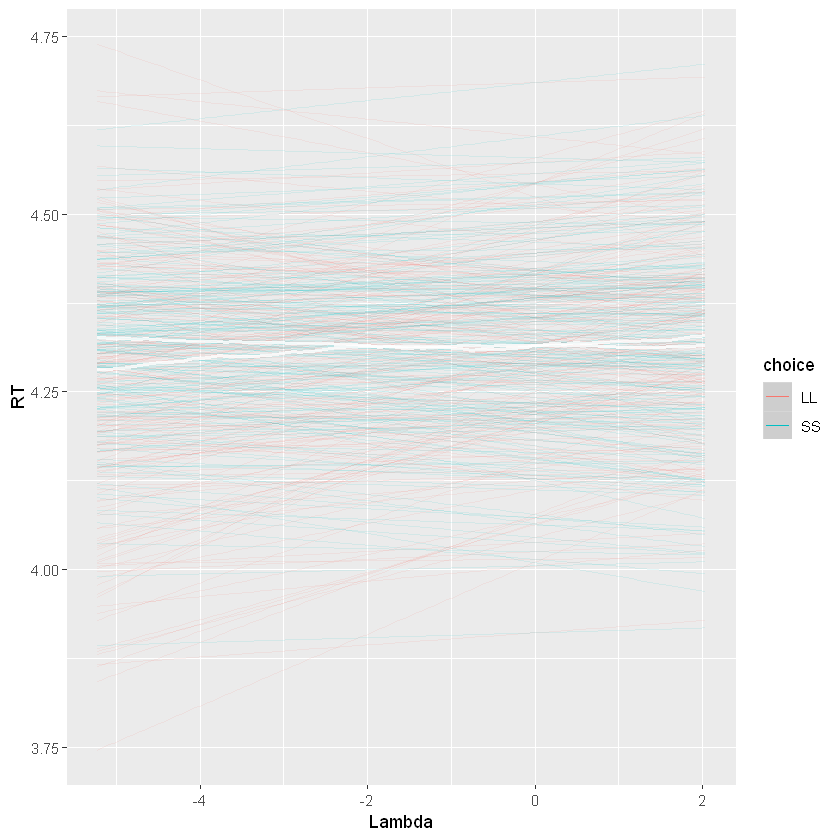

In [45]:
marginal_effects(m_inter, spaghetti=TRUE, nsamples=200)